In [79]:
from data_treat.get_ready_data import get_data
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import roc_curve, precision_recall_curve, auc # метрики качества
from sklearn.metrics import confusion_matrix, accuracy_score # метрики качества
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from data_treat.data_normalizer import CustomNormalizer

In [80]:
COLUMNS = ["distance_from_home","distance_from_last_transaction","ratio_to_median_purchase_price",
           "repeat_retailer","used_chip","used_pin_number","online_order", "fraud"]

In [81]:
data = get_data()
pd.value_counts(data['fraud'])

0.0    87403
1.0    87403
Name: fraud, dtype: int64

In [82]:
data.values

array([[2.50921849e+00, 1.08003881e+00, 5.98947320e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.71789253e+01, 3.12930144e-02, 4.35774009e+00, ...,
        0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.55454900e+01, 4.22249455e-01, 5.12933117e+00, ...,
        0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       ...,
       [7.44480304e+00, 1.53367914e-01, 9.77118828e-01, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [2.79026087e+02, 6.26576392e+00, 5.67989492e-01, ...,
        0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [8.01793124e+00, 9.74114346e+00, 3.52035616e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00]])

In [83]:
data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
67389,2.509218,1.080039,0.598947,1.0,1.0,0.0,0.0,0.0
171043,17.178925,0.031293,4.357740,1.0,1.0,0.0,1.0,1.0
206068,15.545490,0.422249,5.129331,1.0,0.0,0.0,1.0,1.0
715226,0.576530,0.083262,4.369960,0.0,0.0,0.0,1.0,1.0
55548,10.364612,0.103719,0.068207,1.0,1.0,0.0,1.0,0.0


In [84]:
target_variable_name = 'fraud'
labels = data[target_variable_name]
data = data.drop(target_variable_name, axis=1)


In [85]:
labels.head()


67389     0.0
171043    1.0
206068    1.0
715226    1.0
55548     0.0
Name: fraud, dtype: float64

In [86]:
data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order
67389,2.509218,1.080039,0.598947,1.0,1.0,0.0,0.0
171043,17.178925,0.031293,4.357740,1.0,1.0,0.0,1.0
206068,15.545490,0.422249,5.129331,1.0,0.0,0.0,1.0
715226,0.576530,0.083262,4.369960,0.0,0.0,0.0,1.0
55548,10.364612,0.103719,0.068207,1.0,1.0,0.0,1.0


In [87]:
normaliezed_data = CustomNormalizer.normalize(data)

In [88]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.33)

In [89]:
x_train_n, x_test_n, y_train_n, y_test_n = train_test_split(normaliezed_data, labels, test_size=0.33)

In [90]:
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [91]:
x_train_n = x_train_n.to_numpy()
x_test_n = x_test_n.to_numpy()
y_train_n = y_train_n.to_numpy()
y_test_n = y_test_n.to_numpy()

In [92]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

Анализ данных без нормализации

In [93]:
def KNN_test(k):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    return accuracy_score(y_test, predictions)

In [94]:
best_acr = 0
best_k = 0

for k in range(1, 20):
    res = KNN_test(k)
    if res > best_acr:
        best_acr = res
        best_k = k

    

In [95]:
print(best_acr)
print(k)

0.9723676455292445
19


In [96]:
model = KNeighborsClassifier(n_neighbors=19)
model.fit(x_train, y_train)
predictions = model.predict(x_test)

In [97]:
confusion_matrix(y_test, predictions)

array([[26389,  2491],
       [   40, 28766]], dtype=int64)

In [98]:
accuracy_score(y_test, predictions)

0.9561245362826336

In [99]:
test_probabilities = model.predict_proba(x_test)
test_probabilities = test_probabilities[:, 1]
pr_auc_value = average_precision_score(y_test, test_probabilities)
false_positive_rates, true_positive_rates, threshold = roc_curve(y_test, test_probabilities)

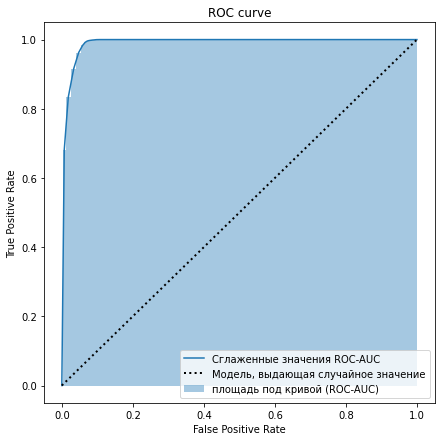

In [100]:
plt.figure(figsize=(7, 7))

# рисуем кривую
plt.plot(false_positive_rates, true_positive_rates, label='Сглаженные значения ROC-AUC')

# кривая, соответствующая случайному угадыванию
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', label='Модель, выдающая случайное значение')

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.fill_between(false_positive_rates, true_positive_rates, step="mid", alpha=0.4, label='площадь под кривой (ROC-AUC)')
plt.legend()
plt.show()

In [101]:
from sklearn.metrics import roc_auc_score

In [102]:
roc_auc_value = roc_auc_score(y_test, test_probabilities)

print("ROC-AUC на тестовой выборке:", roc_auc_value)

ROC-AUC на тестовой выборке: 0.989507546351243


Анализ данных с нормализацией

In [103]:
def KNN_test(k):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(x_train_n, y_train_n)
    predictions = model.predict(x_test_n)
    return accuracy_score(y_test_n, predictions)

In [104]:
best_acr = 0
best_k = 0

for k in range(1, 20):
    res = KNN_test(k)
    if res > best_acr:
        best_acr = res
        best_k = k

    

In [105]:
print(best_acr)
print(k)

0.9972263634157335
19


In [106]:
model = KNeighborsClassifier(n_neighbors=19)
model.fit(x_train_n, y_train_n)
predictions = model.predict(x_test_n)

In [107]:
confusion_matrix(y_test_n, predictions)

array([[28591,   236],
       [   51, 28808]], dtype=int64)

In [108]:
accuracy_score(y_test_n, predictions)

0.9950247893769719

In [109]:
test_probabilities = model.predict_proba(x_test_n)
test_probabilities = test_probabilities[:, 1]
pr_auc_value = average_precision_score(y_test_n, test_probabilities)
false_positive_rates, true_positive_rates, threshold = roc_curve(y_test_n, test_probabilities)

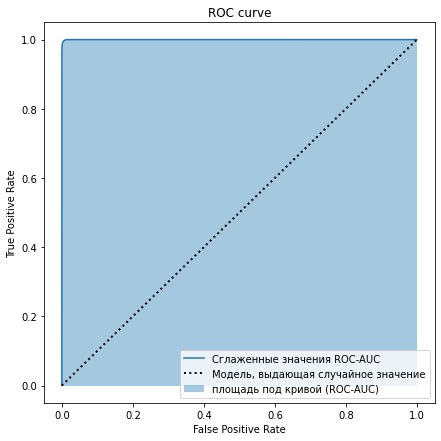

In [110]:
plt.figure(figsize=(7, 7))

# рисуем кривую
plt.plot(false_positive_rates, true_positive_rates, label='Сглаженные значения ROC-AUC')

# кривая, соответствующая случайному угадыванию
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', label='Модель, выдающая случайное значение')

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.fill_between(false_positive_rates, true_positive_rates, step="mid", alpha=0.4, label='площадь под кривой (ROC-AUC)')
plt.legend()
plt.show()

In [111]:
from sklearn.metrics import roc_auc_score
roc_auc_value = roc_auc_score(y_test_n, test_probabilities)

print("ROC-AUC на тестовой выборке:", roc_auc_value)

ROC-AUC на тестовой выборке: 0.999828439302219
